In [43]:
#imports
import numpy as np 
import math

import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

**Data Prep**

In [2]:
df_10= pd.read_csv('nse_10yrs.csv')

In [3]:
dates=[]
for i in range(len(df_10)):
    dates.append(datetime.strptime(df_10['Date'][i],"%d-%m-%Y"))

In [4]:
dates=pd.DataFrame({'dates':dates})

In [5]:
df_10= pd.concat([df_10,dates],axis='columns',copy='False')

In [6]:
df_10

,Date,Open,High,Low,Close,Adj Close,Volume,dates
0,01-02-2010,4882.049805,4918.799805,4827.149902,4899.700195,4899.700195,0.0,2010-02-01
1,02-02-2010,4907.850098,4951.149902,4814.100098,4830.100098,4830.100098,0.0,2010-02-02
2,03-02-2010,4831.000000,4949.149902,4831.000000,4931.850098,4931.850098,0.0,2010-02-03
3,04-02-2010,4931.299805,4931.299805,4832.350098,4845.350098,4845.350098,0.0,2010-02-04
4,05-02-2010,4819.649902,4827.000000,4692.350098,4718.649902,4718.649902,0.0,2010-02-05
...,...,...,...,...,...,...,...,...
2468,27-01-2020,12197.099610,12216.599610,12107.000000,12119.000000,12119.000000,441200.0,2020-01-27
2469,28-01-2020,12148.099610,12163.549810,12024.500000,12055.799810,12055.799810,478500.0,2020-01-28
2470,29-01-2020,12114.900390,12169.599610,12103.799810,12129.500000,12129.500000,514400.0,2020-01-29
2471,30-01-2020,12147.750000,12150.299810,12010.599610,12035.799810,12035.799810,538100.0,2020-01-30


In [7]:
df_10['dates']=pd.to_datetime(df_10['dates'])
df_10=df_10.set_index('dates')
df_10

,Date,Open,High,Low,Close,Adj Close,Volume
dates,,,,,,,
2010-02-01,01-02-2010,4882.049805,4918.799805,4827.149902,4899.700195,4899.700195,0.0
2010-02-02,02-02-2010,4907.850098,4951.149902,4814.100098,4830.100098,4830.100098,0.0
2010-02-03,03-02-2010,4831.000000,4949.149902,4831.000000,4931.850098,4931.850098,0.0
2010-02-04,04-02-2010,4931.299805,4931.299805,4832.350098,4845.350098,4845.350098,0.0
2010-02-05,05-02-2010,4819.649902,4827.000000,4692.350098,4718.649902,4718.649902,0.0
...,...,...,...,...,...,...,...
2020-01-27,27-01-2020,12197.099610,12216.599610,12107.000000,12119.000000,12119.000000,441200.0
2020-01-28,28-01-2020,12148.099610,12163.549810,12024.500000,12055.799810,12055.799810,478500.0
2020-01-29,29-01-2020,12114.900390,12169.599610,12103.799810,12129.500000,12129.500000,514400.0


In [8]:
df_10=df_10.dropna(axis="rows")
df_10.isnull().sum()
df_10.shape

(2449, 7)

In [9]:
df_close=df_10.iloc[:,4]
df_close

dates
2010-02-01     4899.700195
2010-02-02     4830.100098
2010-02-03     4931.850098
2010-02-04     4845.350098
2010-02-05     4718.649902
                  ...     
2020-01-27    12119.000000
2020-01-28    12055.799810
2020-01-29    12129.500000
2020-01-30    12035.799810
2020-01-31    11962.099610
Name: Close, Length: 2449, dtype: float64

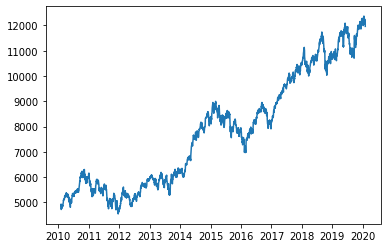

In [10]:
plt.plot(df_close)

In [11]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

**Normalizing the Data**

In [12]:
sc=StandardScaler()

df_close_scaled= sc.fit_transform(df_close.values.reshape(-1, 1))


In [13]:
df_train=df_close_scaled[0:2000]
df_test= df_close_scaled[2000:]

In [14]:
X,Y=create_dataset(df_train,df_train,time_steps=50)
X_val,y_val=create_dataset(df_test,df_test,time_steps=50)

**Setting up hyper parameters**

In [27]:
learning_rate = 0.0001    
nepoch = 25               
T = 50                   # length of sequence
hidden_dim = 200         
output_dim = 1

bptt_truncate = 5
min_clip_value = -10
max_clip_value = 10

**Xavier Initialization**


In [18]:
scale = 1/max(1., (2+2)/2.)
limit = math.sqrt(3.0 * scale)
weights = np.random.uniform(-limit, limit, size=(hidden_dim,T))
weights.shape




yes


In [19]:
U = np.random.uniform(0, 1, (hidden_dim, T))
W = np.random.uniform(0, 1, (hidden_dim, hidden_dim))
V = np.random.uniform(0, 1, (output_dim, hidden_dim))



yes


In [21]:
U=np.random.uniform(-limit, limit, size=(hidden_dim,T))
W= np.random.uniform(-limit, limit, size=(hidden_dim,hidden_dim))
V= np.random.uniform(-limit, limit, size=(output_dim ,hidden_dim))

In [22]:
U.shape

(200, 50)

In [23]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [24]:
losses=[]

**Training**

In [28]:
for epoch in range(nepoch):
    # check loss on train
    loss = 0.0
    
    # do a forward pass to get prediction
    for i in range(Y.shape[0]):
        x, y = X[i], Y[i]                    # get input, output values of each record
        prev_s = np.zeros((hidden_dim, 1))   # here, prev-s is the value of the previous activation of hidden layer; which is initialized as all zeroes
        for t in range(T):
            new_input = np.zeros(x.shape)    # we then do a forward pass for every timestep in the sequence
            new_input[t] = x[t]              # for this, we define a single input for that timestep
            mulu = np.dot(U, new_input)
            mulw = np.dot(W, prev_s)
            add = mulw + mulu
            s = sigmoid(add)
            mulv = np.dot(V, s)
            prev_s = s

    # calculate error 
        loss_per_record = (y - mulv)**2 / 2
        loss += loss_per_record
    loss = loss / float(y.shape[0])
  
    losses.append(loss)
    print('Epoch: ', epoch + 1, ', Loss: ', loss)
    
    # train model
    for i in range(Y.shape[0]):
        x, y = X[i], Y[i]
    
        layers = []
        prev_s = np.zeros((hidden_dim, 1))
        dU = np.zeros(U.shape)
        dV = np.zeros(V.shape)
        dW = np.zeros(W.shape)
        
        dU_t = np.zeros(U.shape)
        dV_t = np.zeros(V.shape)
        dW_t = np.zeros(W.shape)
        
        dU_i = np.zeros(U.shape)
        dW_i = np.zeros(W.shape)
        
        # forward pass
        for t in range(T):
            new_input = np.zeros(x.shape)
            new_input[t] = x[t]
            mulu = np.dot(U, new_input)
            mulw = np.dot(W, prev_s)
            add = mulw + mulu
            s = sigmoid(add)
            mulv = np.dot(V, s)
            layers.append({'s':s, 'prev_s':prev_s})
            prev_s = s
            
        # derivative of pred
        dmulv = (mulv - y)
        
        # backward pass
        for t in range(T):
            dV_t = np.dot(dmulv, np.transpose(layers[t]['s']))
            dsv = np.dot(np.transpose(V), dmulv)
            
            ds = dsv
            dadd = add * (1 - add) * ds
            
            dmulw = dadd * np.ones_like(mulw)

            dprev_s = np.dot(np.transpose(W), dmulw)


            for i in range(t-1, max(-1, t-bptt_truncate-1), -1):
                ds = dsv + dprev_s
                dadd = add * (1 - add) * ds

                dmulw = dadd * np.ones_like(mulw)
                dmulu = dadd * np.ones_like(mulu)

                dW_i = np.dot(W, layers[t]['prev_s'])
                dprev_s = np.dot(np.transpose(W), dmulw)

                new_input = np.zeros(x.shape)
                new_input[t] = x[t]
                dU_i = np.dot(U, new_input)
                dx = np.dot(np.transpose(U), dmulu)

                dU_t += dU_i
                dW_t += dW_i
                
            dV += dV_t
            dU += dU_t
            dW += dW_t
            
            if dU.max() > max_clip_value:
                dU[dU > max_clip_value] = max_clip_value
            if dV.max() > max_clip_value:
                dV[dV > max_clip_value] = max_clip_value
            if dW.max() > max_clip_value:
                dW[dW > max_clip_value] = max_clip_value
                
            
            if dU.min() < min_clip_value:
                dU[dU < min_clip_value] = min_clip_value
            if dV.min() < min_clip_value:
                dV[dV < min_clip_value] = min_clip_value
            if dW.min() < min_clip_value:
                dW[dW < min_clip_value] = min_clip_value
        
        # update
        U -= learning_rate * dU
        V -= learning_rate * dV
        W -= learning_rate * dW

Epoch:  1 , Loss:  [[1189.14434093]]
Epoch:  2 , Loss:  [[781.52663554]]
Epoch:  3 , Loss:  [[798.28885098]]
Epoch:  4 , Loss:  [[763.66694432]]
Epoch:  5 , Loss:  [[881.15696491]]
Epoch:  6 , Loss:  [[811.73719929]]
Epoch:  7 , Loss:  [[799.9018402]]
Epoch:  8 , Loss:  [[759.05485972]]
Epoch:  9 , Loss:  [[751.08584477]]
Epoch:  10 , Loss:  [[838.52777795]]
Epoch:  11 , Loss:  [[805.8714004]]
Epoch:  12 , Loss:  [[765.49193669]]
Epoch:  13 , Loss:  [[795.25356164]]
Epoch:  14 , Loss:  [[789.08359558]]
Epoch:  15 , Loss:  [[779.60189994]]
Epoch:  16 , Loss:  [[812.97667382]]
Epoch:  17 , Loss:  [[772.13932956]]
Epoch:  18 , Loss:  [[768.97425381]]
Epoch:  19 , Loss:  [[851.26853575]]
Epoch:  20 , Loss:  [[779.1426333]]
Epoch:  21 , Loss:  [[780.79179632]]
Epoch:  22 , Loss:  [[811.44964177]]
Epoch:  23 , Loss:  [[811.35341115]]
Epoch:  24 , Loss:  [[1015.6007158]]
Epoch:  25 , Loss:  [[787.1956222]]


In [29]:
losses


[array([[33661.0353852]]),
 array([[66177.05276455]]),
 array([[5537.20328993]]),
 array([[47280.03379166]]),
 array([[82365.37642562]]),
 array([[65565.28865065]]),
 array([[40934.33788576]]),
 array([[4269.77669606]]),
 array([[1531.12928223]]),
 array([[13327.88333881]]),
 array([[4995.01426689]]),
 array([[1189.14434093]]),
 array([[781.52663554]]),
 array([[798.28885098]]),
 array([[763.66694432]]),
 array([[881.15696491]]),
 array([[811.73719929]]),
 array([[799.9018402]]),
 array([[759.05485972]]),
 array([[751.08584477]]),
 array([[838.52777795]]),
 array([[805.8714004]]),
 array([[765.49193669]]),
 array([[795.25356164]]),
 array([[789.08359558]]),
 array([[779.60189994]]),
 array([[812.97667382]]),
 array([[772.13932956]]),
 array([[768.97425381]]),
 array([[851.26853575]]),
 array([[779.1426333]]),
 array([[780.79179632]]),
 array([[811.44964177]]),
 array([[811.35341115]]),
 array([[1015.6007158]]),
 array([[787.1956222]])]

**Predictions**

In [35]:
from scipy.special import expit


preds = []
for i in range(y_val.shape[0]):
    x, y = X_val[i], y_val[i]
    prev_s = np.zeros((hidden_dim, 1))
    # Forward pass
    for t in range(T):
        mulu = np.dot(U, x)
        mulw = np.dot(W, prev_s)
        add = mulw + mulu
        s = expit(add)
        mulv = np.dot(V, s)
        prev_s = s

    preds.append(mulv)
    
preds = np.array(preds)

In [37]:
preds_scaled= sc.inverse_transform(preds)

In [46]:
mean_squared_error(y_val,preds_scaled),mean_absolute_error(y_val,preds_scaled)

(103453373.1522158, 10171.203129151221)